# Decision Tree

### Fit
1. Create the root node
2. Using greedy search loop over all features and thresholds to find the best information gain
3. Save the best split feature and split threshold at each node
4. Repeat the steps recursively until stopping criteria (max depth, minimum samples in a node, no class distribution) is met
5. When the leaf node is reached store the most common class label

### Predict
1. Traverse the tree recursively
2. At each node look at the best split feature of the input vector $\mathbf{x}$ and go left or right depending on $\mathbf{x}$[feature_idx] $\leq$ threshold
3. When leaf node is reached return the stored most common class label

### Entropy

$$
\begin{align*}
E &= - \sum_{i}^{N} p(x_i) \log_N{p(x_i)} \\
p(x) &= \frac{\# x}{n} \\
\# x &= \text{number of labels } x \\
n &= \text{number of samples} \\
N &= \text{number of classes}
\end{align*}
$$

### Information gain
$$ \text{IG} = E(\text{parent}) - [\text{weighted average}] \cdot E(\text{children}) $$


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [7]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.03  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

In [8]:
def entropy(x):
    probabilites = np.bincount(x) / len(x)
    classes = len(set(x))
    if classes != 1:
        return -1 * np.sum([p * np.log(p) / np.log(classes) for p in probabilites if p > 0])
    else:
        return 0

class Node:

    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value != None
    
class DecisionTree:

    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        # Start growing at root node
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        
        return self._traverse_tree(x, node.right)


    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Stopping criteria
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        best_feature, best_threshold = self._best_criteria(X, y, feat_idxs)

        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        
        return Node(best_feature, best_threshold, left, right)
        
    def _most_common_label(self, y):
        counter = Counter(y)
        return counter.most_common(1)[0][0]
    
    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:

            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for threshold in thresholds:

                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = threshold

        return split_idx, split_threshold
    
    def _information_gain(self, y, X_column, split_threshold):
        parent_entropy = entropy(y)

        left_idxs, right_idxs = self._split(X_column, split_threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r
        return parent_entropy - child_entropy

    def _split(self, X_column, split_threshold):
        left_idxs = np.argwhere(X_column <= split_threshold).flatten()
        right_idxs = np.argwhere(X_column > split_threshold).flatten()
        return left_idxs, right_idxs

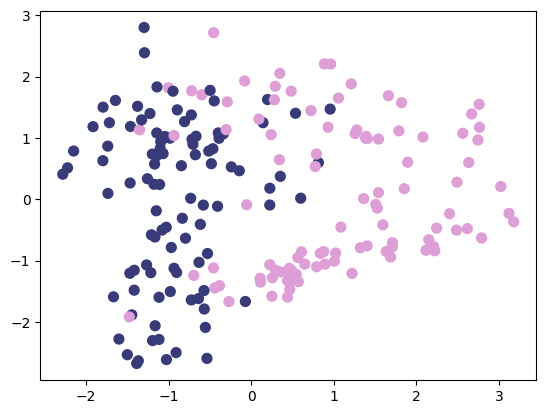

In [9]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=200, n_classes=2, n_features=2, n_informative=2, n_redundant=0)
X_train, y_train = X[:int(len(X)/2)], y[:int(len(X)/2)]
X_test, y_test = X[int(len(X)/2):], y[int(len(X)/2):]
plot_2d_clf_problem(X, y)

Accuracy train: 1.0
Accuracy test: 0.84


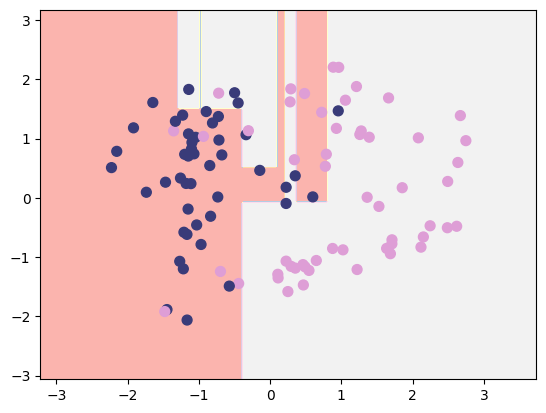

In [10]:
model = DecisionTree()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print(f'Accuracy train: {np.mean(y_pred == y_train)}')
y_pred = model.predict(X_test)
print(f'Accuracy test: {np.mean(y_pred == y_test)}')
plot_2d_clf_problem(X_test, y_test, model.predict)

In [11]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

data = datasets.load_breast_cancer()
X, y = data['data'], data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [12]:
model = DecisionTree(max_depth=30)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'Accuracy: {np.mean(y_pred == y_test)}')

Accuracy: 0.9298245614035088
